# This notebook is for testing the different Personalized VFM functions we created, designing metrics for comparison and finding the best function for our case

# Evaluations 05.02.26

# 🧪 The "Vibe" Tournament: Finding the Perfect Scoring Engine

**The Goal:** We have built a system that scores Airbnb listings based on **Price**, **Quality** (Ratings), and **Vibe** (Neighborhood Personality). But how do we combine these numbers into a single "Personalized Score"? 

We designed an experiment to compare **three different mathematical approaches** against a standard **Baseline**. We want to prove that adding personalization isn't just a gimmick-it actually creates *better utility* for the user.

**The Hypothesis:** A sophisticated function (like Log-Utility or Ratio) will outperform a simple Linear sum because it handles the trade-offs between Price and Vibe more realistically (e.g., diminishing returns).

## 🥊 Round 1: The Contenders (Scoring Functions)

We are pitting four algorithms against each other. All inputs ($Q, A, V, P$) are normalized to $[0,1]$.

### 1. The Baseline (The Control Group)
$$S_{base} = \ln(Q) - \ln(P) + \ln(1 + 0.3 \cdot A)$$
* **The Logic:** This represents a "Smart Default." It balances Rating ($Q$) and Price ($P$) with a small bonus for Amenities ($A$), but it is **blind** to specific neighborhood vibes.
* **Why we use it:** To prove our model adds value, we must beat this.

### 2. The Linear Model (The "Points System")
$$S = w_Q \cdot Q + w_A \cdot A + w_V \cdot V - w_P \cdot P$$
* **The Logic:** A simple additive score. You get points for good things, lose points for price.
* **The Flaw:** It allows "Compensatory Behavior." A massively expensive house can still rank high if it has enough amenities to "outweigh" the cost.

### 3. The Ratio Model (The "Deal Hunter")
$$S = \frac{Q^{w_Q} \cdot (1+V)^{w_V}}{P^{w_P}}$$
* **The Logic:** Based on the Cobb-Douglas production function. Because we multiply, if *any* factor is bad (e.g., Price is too high), the whole score crashes.
* **Why we use it:** It creates strict penalties. It's excellent for budget users who cannot compromise.

### 4. The Log-Utility Model (The Economist's Choice)
$$S = w_Q \ln(Q) - w_P \ln(P) + w_V \ln(1+V)$$
* **The Logic:** Uses logarithms to model **Diminishing Returns**.
* **The "Why":** In real life, the difference between a 3-star and 4-star hotel matters more than 4-star vs 5-star. This smoothes out outliers so one mansion doesn't dominate the list.

## 🎭 Stress Testing: The Personas

We can't evaluate personalization on just one user. We created **8 Distinct Profiles** to stress-test the math in extreme scenarios:

* **The Extremes:** 
    * *The Penny Pincher* (Only cares about Price).
    * *The Perfectionist* (Only cares about Quality).
* **The Vibe Hunters:** 
    * *The Party Animal* (Needs Nightlife, ignores noise/comfort).
    * *The Zen Master* (Needs Nature, hates Nightlife).
* **The Realists:** 
    * *Student, Family, Digital Nomad.*

**Why?** If our algorithm works, the *Penny Pincher* should get a completely different list than the *Perfectionist*.

## 📏 The Judges: How We Measure Success

Since we don't have live user clicks, we rely on **Economic Theory** and **Statistical attributes**. We evaluate across varying list depths ($K=5, 10, 20, 50$).

### 1. Accuracy: Vibe Gain ($\Delta V$)
* **Formula:** $Avg(V_{Personalized}) - Avg(V_{Baseline})$
* **The Question:** *"Did I actually get the vibe I asked for?"*
* **Goal:** We want this positive. If I ask for "Party," my results should be "Partier" than the city average.

### 2. Utility: Price Efficiency ($\Delta P$)
* **Formula:** $Avg(P_{Personalized}) - Avg(P_{Baseline})$
* **The Question:** *"Did the budget user save money?"*
* **Goal:** For the "Student" and "Penny Pincher," this must be negative.

### 3. Distinctness: Jaccard Overlap
* **The Question:** *"Is this actually personalized?"*
* **Goal:** We want **Low Overlap** with the Baseline. If the Overlap is 90%, our algorithm is just a placebo.

### 4. Consistency: Inter-Persona Diversity
* **The Question:** *"Do different people see different things?"*
* **Goal:** We measure the overlap between the *Student's* list and the *Family's* list. This should be near zero.

## 🚀 Advanced Metrics: Coverage & Optimality

To verify our system is "Production-Ready," we ran two advanced tests:

### 1. Catalog Coverage (Diversity)
* **What it is:** The % of our total inventory that gets recommended across all our personas.
* **Why it matters:** A bad algorithm just recommends the same 10 "Superhosts" to everyone. A good algorithm digs deep into the "Long Tail" to find hidden gems for specific niches.

### 2. Pareto Efficiency (Optimality)
* **The Concept:** A listing is "Dominated" if there exists another listing that is **Cheaper** AND has a **Better Vibe**.
* **The Metric:** Average number of "Dominators" per recommendation.
* **Goal:** We want this close to **0**. It proves we aren't leaving "free utility" on the table.

--------------------

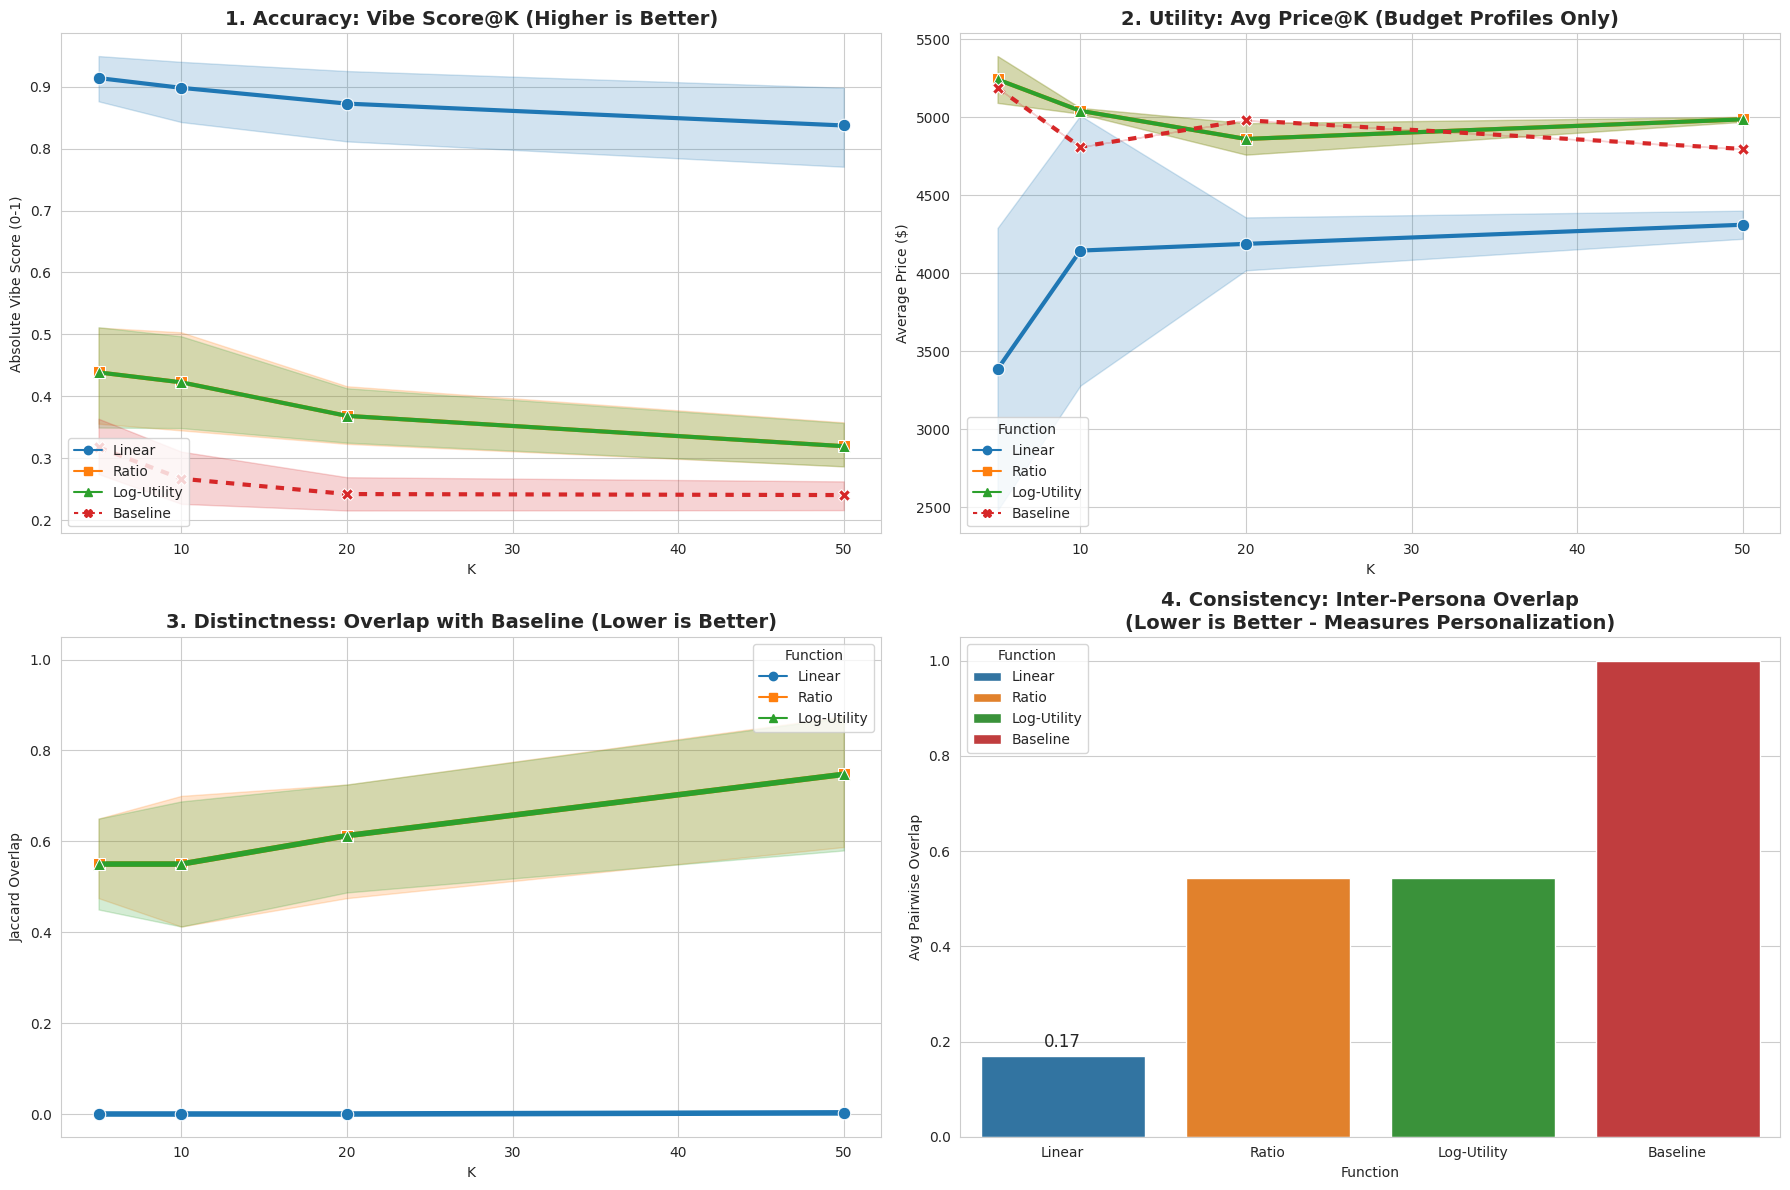


--- 💸 EXTREME BUDGET SAVINGS (Penny Pincher @ K=20) ---
               Avg_Price
Function                
Linear       4018.523438
Log-Utility  4961.391113
Ratio        4961.391113
Baseline     4980.325684

--- 🎯 OVERALL VIBE ACCURACY (K=20) ---
             Avg_Vibe_Score
Function                   
Linear             0.872715
Log-Utility        0.368356
Ratio              0.368356
Baseline           0.242060


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from itertools import combinations

# ==========================================
# 1. SETUP & DATA LOADING
# ==========================================
K_LEVELS = [5, 10, 20, 50]
SAMPLE_FRAC = 0.5 

# Load & Sample
df_spark = spark.read.format("delta").load("dbfs:/FileStore/osm_pipeline/final_listings_scored")
df = df_spark.sample(fraction=SAMPLE_FRAC, seed=42).toPandas()

# Pre-processing
numeric_cols = ["relativePrice_01", "WeightedRating_01", "amenityScore_01", "baseline_vfm_log", "price"]
vibe_cols = [c for c in df.columns if "_score_norm" in c]

for c in numeric_cols + vibe_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)

EPS = 1e-6
df["P"] = df["relativePrice_01"] + EPS 
df["Q"] = df["WeightedRating_01"] + EPS
df["A"] = df["amenityScore_01"]
df["Base_Score"] = df["baseline_vfm_log"]

# ==========================================
# 2. THE STORY-DRIVEN PERSONAS (8 Profiles)
# ==========================================
personas = {
    # --- GROUP A: THE EXTREMES ---
    "Penny Pincher": { 
        # Extreme Price Sensitivity. Doesn't care about anything else.
        "wP": 10, "wQ": 1, "wA": 0, "wV": 1,
        "vibe_pref": {"Daily_Essentials_score_norm": 1.0, "Food_Drinks_score_norm": 0.0, "Outdoor_Attractions_score_norm": 0.0, "Indoor_Culture_score_norm": 0.0, "Shopping_score_norm": 0.0}
    },
    "The Perfectionist": { 
        # Extreme Quality. Price is irrelevant.
        "wP": 1, "wQ": 10, "wA": 5, "wV": 3,
        "vibe_pref": {"Indoor_Culture_score_norm": 0.5, "Food_Drinks_score_norm": 0.5, "Outdoor_Attractions_score_norm": 0.0, "Daily_Essentials_score_norm": 0.0, "Shopping_score_norm": 0.0}
    },
    
    # --- GROUP B: THE VIBE HUNTERS ---
    "Party Animal": { 
        # High Vibe (Nightlife). Low standards for house quality.
        "wP": 5, "wQ": 2, "wA": 3, "wV": 10,
        "vibe_pref": {"Food_Drinks_score_norm": 1.0, "Shopping_score_norm": 0.2, "Outdoor_Attractions_score_norm": 0.0, "Indoor_Culture_score_norm": 0.0, "Daily_Essentials_score_norm": 0.0}
    },
    "Zen Master": { 
        # High Vibe (Nature). Active DISLIKE for nightlife (simulated by 0 weight).
        "wP": 4, "wQ": 6, "wA": 4, "wV": 9,
        "vibe_pref": {"Outdoor_Attractions_score_norm": 1.0, "Food_Drinks_score_norm": 0.0, "Indoor_Culture_score_norm": 0.0, "Daily_Essentials_score_norm": 0.0, "Shopping_score_norm": 0.0}
    },

    # --- GROUP C: BALANCED / REALISTIC ---
    "Anxious Parent": { 
        # High Safety (Rating) + Amenities. Moderate Price.
        "wP": 4, "wQ": 9, "wA": 8, "wV": 5,
        "vibe_pref": {"Outdoor_Attractions_score_norm": 0.7, "Daily_Essentials_score_norm": 1.0, "Indoor_Culture_score_norm": 0.3, "Food_Drinks_score_norm": 0.0, "Shopping_score_norm": 0.0}
    },
    "Digital Nomad": { 
        # Needs Workspace (Amenities) + Coffee (Essentials/Food).
        "wP": 6, "wQ": 5, "wA": 9, "wV": 6,
        "vibe_pref": {"Food_Drinks_score_norm": 0.6, "Daily_Essentials_score_norm": 0.8, "Indoor_Culture_score_norm": 0.0, "Outdoor_Attractions_score_norm": 0.0, "Shopping_score_norm": 0.0}
    },
    "Shopaholic": {
        # Pure Shopping focus.
        "wP": 3, "wQ": 5, "wA": 5, "wV": 10,
        "vibe_pref": {"Shopping_score_norm": 1.0, "Food_Drinks_score_norm": 0.4, "Indoor_Culture_score_norm": 0.0, "Outdoor_Attractions_score_norm": 0.0, "Daily_Essentials_score_norm": 0.0}
    },
    "Broke Student": {
        # The classic baseline.
        "wP": 9, "wQ": 3, "wA": 2, "wV": 7,
        "vibe_pref": {"Food_Drinks_score_norm": 1.0, "Daily_Essentials_score_norm": 0.5, "Outdoor_Attractions_score_norm": 0.0, "Indoor_Culture_score_norm": 0.0, "Shopping_score_norm": 0.0}
    }
}

# ==========================================
# 3. TOURNAMENT LOOP
# ==========================================
results = []
diversity_results = []
baseline_indices = df.sort_values("Base_Score", ascending=False).index

for p_name, params in personas.items():
    # 1. Calculate User Vibe (V)
    df["V"] = 0
    total_w = sum(params["vibe_pref"].values())
    for col, weight in params["vibe_pref"].items():
        if col in df.columns:
            df["V"] += df[col] * weight
    df["V"] /= (total_w + 1e-6)

    # 2. Score & Sort
    for func in ["Linear", "Ratio", "Log-Utility", "Baseline"]:
        d = df.copy()
        
        if func == "Linear":
            d["Score"] = params["wQ"]*d["Q"] + params["wA"]*d["A"] + params["wV"]*d["V"] - params["wP"]*d["P"]
        elif func == "Ratio":
            d["Score"] = (d["Q"]**params["wQ"] * (1+d["A"])**params["wA"] * (1+d["V"])**params["wV"]) / (d["P"]**params["wP"])
        elif func == "Log-Utility":
            d["Score"] = params["wQ"]*np.log(d["Q"]) - params["wP"]*np.log(d["P"]) + params["wA"]*np.log1p(d["A"]) + params["wV"]*np.log1p(d["V"])
        elif func == "Baseline":
            d["Score"] = d["Base_Score"]

        sorted_df = d.sort_values("Score", ascending=False)
        
        diversity_results.append({
            "Persona": p_name,
            "Function": func,
            "Top50_IDs": set(sorted_df.head(50)["property_id"])
        })

        for k in K_LEVELS:
            topk = sorted_df.head(k)
            avg_vibe = topk["V"].mean()
            avg_price = topk["price"].mean()
            
            if func != "Baseline":
                baseline_k = d.loc[baseline_indices[:k]]
                ids_pers = set(topk["property_id"])
                ids_base = set(baseline_k["property_id"])
                overlap = len(ids_pers.intersection(ids_base)) / k
            else:
                overlap = 1.0

            results.append({
                "Persona": p_name,
                "Function": func,
                "K": k,
                "Overlap": overlap,
                "Avg_Vibe_Score": avg_vibe,
                "Avg_Price": avg_price
            })

res_df = pd.DataFrame(results)

# ==========================================
# 4. PLOTTING (Scientific Palette: Blue, Orange, Green, Red)
# ==========================================
sns.set_style("whitegrid")
palette = {"Linear": "#1f77b4", "Ratio": "#ff7f0e", "Log-Utility": "#2ca02c", "Baseline": "#d62728"} # Red Baseline
markers = {"Linear": "o", "Ratio": "s", "Log-Utility": "^", "Baseline": "X"}
dashes = {"Linear": "", "Ratio": "", "Log-Utility": "", "Baseline": (2,2)}

fig, ax = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Vibe Score @ K
sns.lineplot(data=res_df, x="K", y="Avg_Vibe_Score", hue="Function", style="Function", 
             markers=markers, palette=palette, dashes=dashes, linewidth=3, markersize=9, ax=ax[0,0])
ax[0,0].set_title("1. Accuracy: Vibe Score@K (Higher is Better)", fontsize=14, fontweight='bold')
ax[0,0].set_ylabel("Absolute Vibe Score (0-1)")
ax[0,0].legend(loc='lower left')

# Plot 2: Price @ K (Only for Budget Personas: Student + Penny Pincher)
budget_df = res_df[res_df["Persona"].isin(["Broke Student", "Penny Pincher"])]
sns.lineplot(data=budget_df, x="K", y="Avg_Price", hue="Function", style="Function", 
             markers=markers, palette=palette, dashes=dashes, linewidth=3, markersize=9, ax=ax[0,1])
ax[0,1].set_title("2. Utility: Avg Price@K (Budget Profiles Only)", fontsize=14, fontweight='bold')
ax[0,1].set_ylabel("Average Price ($)")

# Plot 3: Distinctness (Overlap)
overlap_df = res_df[res_df["Function"] != "Baseline"]
sns.lineplot(data=overlap_df, x="K", y="Overlap", hue="Function", style="Function", 
             markers=markers, palette=palette, dashes=dashes, linewidth=4, markersize=9, ax=ax[1,0])
ax[1,0].set_title("3. Distinctness: Overlap with Baseline (Lower is Better)", fontsize=14, fontweight='bold')
ax[1,0].set_ylim(-0.05, 1.05)
ax[1,0].set_ylabel("Jaccard Overlap")

# Plot 4: Consistency (Bar)
div_metrics = []
for func in ["Linear", "Ratio", "Log-Utility", "Baseline"]:
    func_sets = {r["Persona"]: r["Top50_IDs"] for r in diversity_results if r["Function"] == func}
    overlaps = []
    for (p1, s1), (p2, s2) in combinations(func_sets.items(), 2):
        jaccard = len(s1.intersection(s2)) / len(s1.union(s2))
        overlaps.append(jaccard)
    div_metrics.append({"Function": func, "Avg_Inter_Persona_Overlap": np.mean(overlaps)})
div_df = pd.DataFrame(div_metrics)

sns.barplot(data=div_df, x="Function", y="Avg_Inter_Persona_Overlap", hue="Function", 
            palette=palette, ax=ax[1,1], dodge=False)
ax[1,1].set_title("4. Consistency: Inter-Persona Overlap\n(Lower is Better - Measures Personalization)", fontsize=14, fontweight='bold')
ax[1,1].set_ylabel("Avg Pairwise Overlap")
ax[1,1].bar_label(ax[1,1].containers[0], fmt='%.2f', fontsize=12, padding=3)

plt.tight_layout()
plt.show()

# ==========================================
# 5. TABLES (Top 20 Comparison)
# ==========================================
print("\n--- 💸 EXTREME BUDGET SAVINGS (Penny Pincher @ K=20) ---")
penny_savings = res_df[(res_df["Persona"]=="Penny Pincher") & (res_df["K"]==20)]
print(penny_savings.groupby("Function")[["Avg_Price"]].mean().sort_values("Avg_Price"))

print("\n--- 🎯 OVERALL VIBE ACCURACY (K=20) ---")
overall_vibe = res_df[res_df["K"]==20]
print(overall_vibe.groupby("Function")[["Avg_Vibe_Score"]].mean().sort_values("Avg_Vibe_Score", ascending=False))

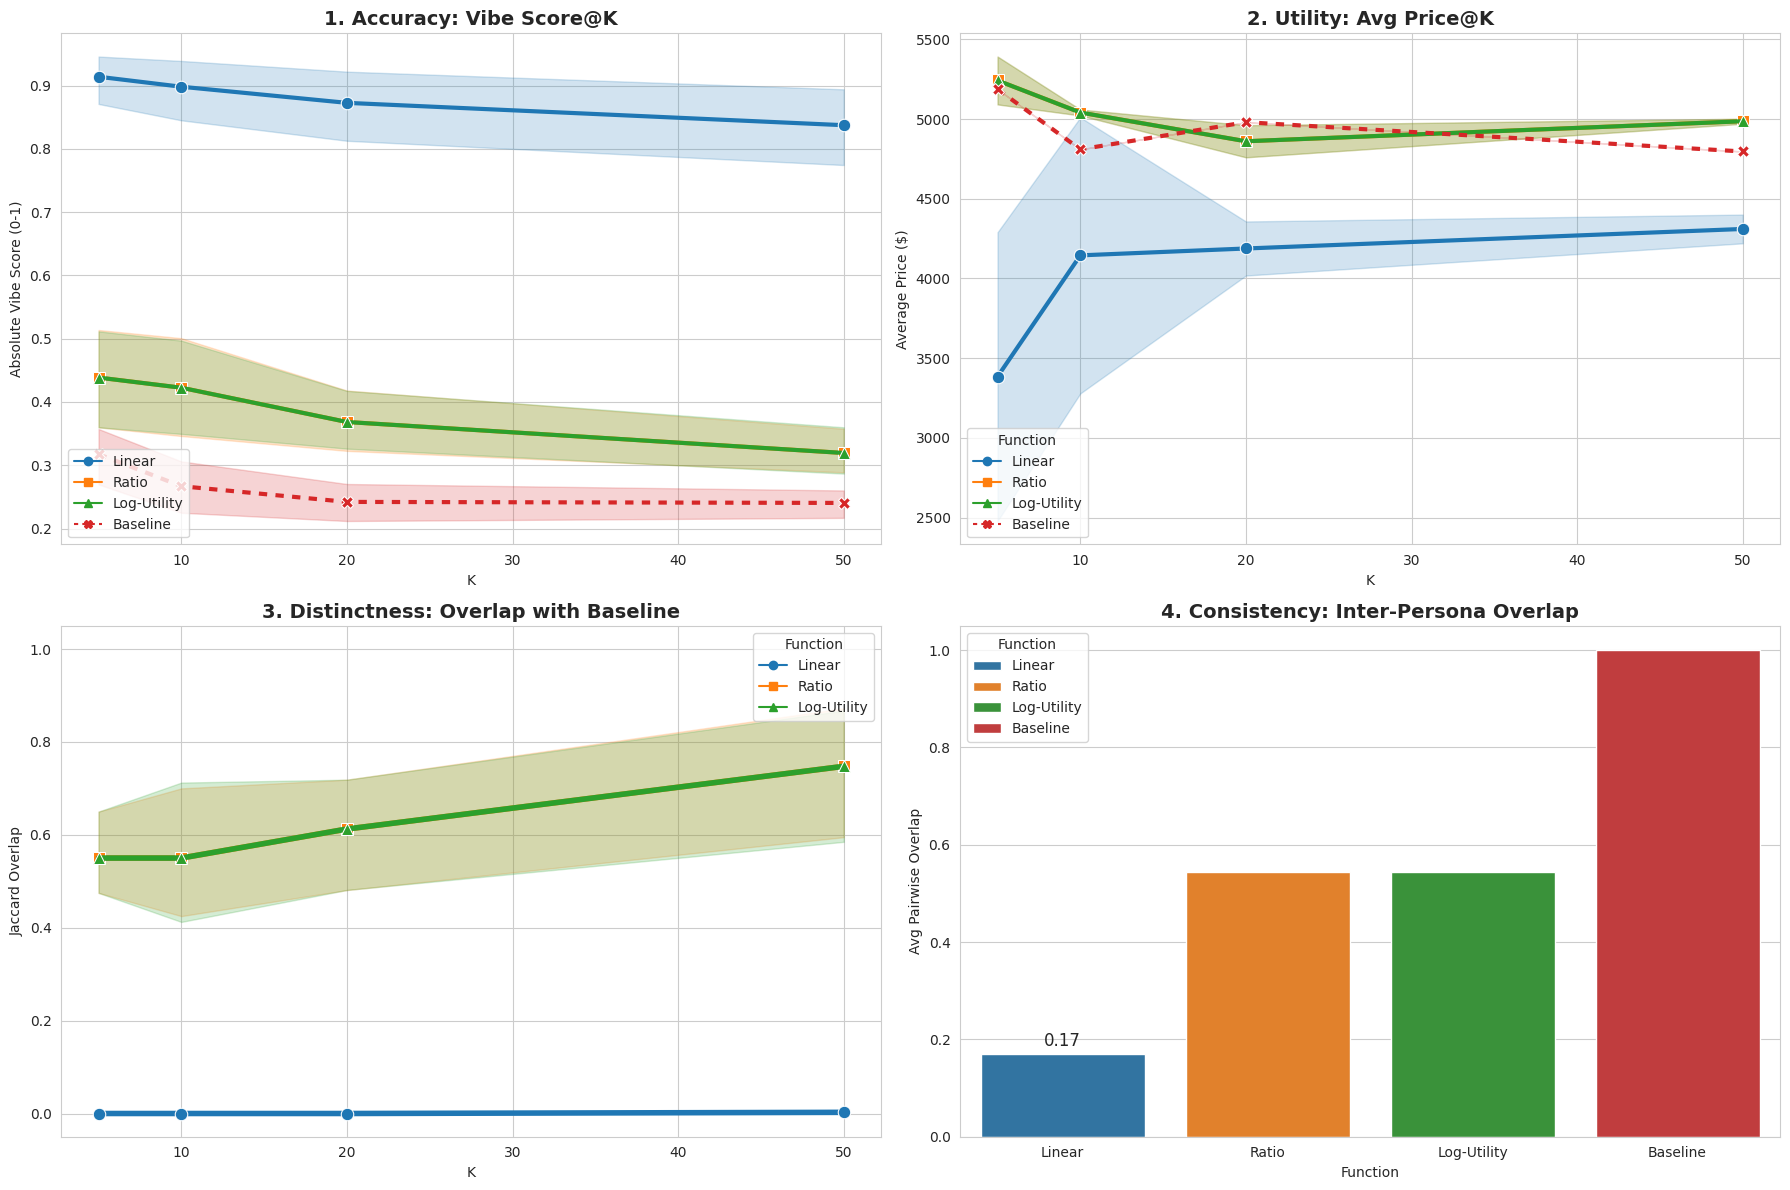


--- 💸 EXTREME BUDGET SAVINGS (Penny Pincher @ K=20) ---
               Avg_Price
Function                
Linear       4018.523438
Log-Utility  4961.391113
Ratio        4961.391113
Baseline     4980.325684

--- 🎯 OVERALL VIBE ACCURACY (K=20) ---
             Avg_Vibe_Score
Function                   
Linear             0.872715
Log-Utility        0.368356
Ratio              0.368356
Baseline           0.242060


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from itertools import combinations

# ==========================================
# 1. SETUP & DATA LOADING
# ==========================================
K_LEVELS = [5, 10, 20, 50]
SAMPLE_FRAC = 0.5 

# Load & Sample
df_spark = spark.read.format("delta").load("dbfs:/FileStore/osm_pipeline/final_listings_scored")
df = df_spark.sample(fraction=SAMPLE_FRAC, seed=42).toPandas()

# Pre-processing
numeric_cols = ["relativePrice_01", "WeightedRating_01", "amenityScore_01", "baseline_vfm_log", "price"]
vibe_cols = [c for c in df.columns if "_score_norm" in c]

for c in numeric_cols + vibe_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)

EPS = 1e-6
df["P"] = df["relativePrice_01"] + EPS 
df["Q"] = df["WeightedRating_01"] + EPS
df["A"] = df["amenityScore_01"]
df["Base_Score"] = df["baseline_vfm_log"]

# ==========================================
# 2. THE STORY-DRIVEN PERSONAS (8 Profiles)
# ==========================================
personas = {
    # --- GROUP A: THE EXTREMES ---
    "Penny Pincher": { 
        # Extreme Price Sensitivity. Doesn't care about anything else.
        "wP": 10, "wQ": 1, "wA": 0, "wV": 1,
        "vibe_pref": {"Daily_Essentials_score_norm": 1.0, "Food_Drinks_score_norm": 0.0, "Outdoor_Attractions_score_norm": 0.0, "Indoor_Culture_score_norm": 0.0, "Shopping_score_norm": 0.0}
    },
    "The Perfectionist": { 
        # Extreme Quality. Price is irrelevant.
        "wP": 1, "wQ": 10, "wA": 5, "wV": 3,
        "vibe_pref": {"Indoor_Culture_score_norm": 0.5, "Food_Drinks_score_norm": 0.5, "Outdoor_Attractions_score_norm": 0.0, "Daily_Essentials_score_norm": 0.0, "Shopping_score_norm": 0.0}
    },
    
    # --- GROUP B: THE VIBE HUNTERS ---
    "Party Animal": { 
        # High Vibe (Nightlife). Low standards for house quality.
        "wP": 5, "wQ": 2, "wA": 3, "wV": 10,
        "vibe_pref": {"Food_Drinks_score_norm": 1.0, "Shopping_score_norm": 0.2, "Outdoor_Attractions_score_norm": 0.0, "Indoor_Culture_score_norm": 0.0, "Daily_Essentials_score_norm": 0.0}
    },
    "Zen Master": { 
        # High Vibe (Nature). Active DISLIKE for nightlife (simulated by 0 weight).
        "wP": 4, "wQ": 6, "wA": 4, "wV": 9,
        "vibe_pref": {"Outdoor_Attractions_score_norm": 1.0, "Food_Drinks_score_norm": 0.0, "Indoor_Culture_score_norm": 0.0, "Daily_Essentials_score_norm": 0.0, "Shopping_score_norm": 0.0}
    },

    # --- GROUP C: BALANCED / REALISTIC ---
    "Anxious Parent": { 
        # High Safety (Rating) + Amenities. Moderate Price.
        "wP": 4, "wQ": 9, "wA": 8, "wV": 5,
        "vibe_pref": {"Outdoor_Attractions_score_norm": 0.7, "Daily_Essentials_score_norm": 1.0, "Indoor_Culture_score_norm": 0.3, "Food_Drinks_score_norm": 0.0, "Shopping_score_norm": 0.0}
    },
    "Digital Nomad": { 
        # Needs Workspace (Amenities) + Coffee (Essentials/Food).
        "wP": 6, "wQ": 5, "wA": 9, "wV": 6,
        "vibe_pref": {"Food_Drinks_score_norm": 0.6, "Daily_Essentials_score_norm": 0.8, "Indoor_Culture_score_norm": 0.0, "Outdoor_Attractions_score_norm": 0.0, "Shopping_score_norm": 0.0}
    },
    "Shopaholic": {
        # Pure Shopping focus.
        "wP": 3, "wQ": 5, "wA": 5, "wV": 10,
        "vibe_pref": {"Shopping_score_norm": 1.0, "Food_Drinks_score_norm": 0.4, "Indoor_Culture_score_norm": 0.0, "Outdoor_Attractions_score_norm": 0.0, "Daily_Essentials_score_norm": 0.0}
    },
    "Broke Student": {
        # The classic baseline.
        "wP": 9, "wQ": 3, "wA": 2, "wV": 7,
        "vibe_pref": {"Food_Drinks_score_norm": 1.0, "Daily_Essentials_score_norm": 0.5, "Outdoor_Attractions_score_norm": 0.0, "Indoor_Culture_score_norm": 0.0, "Shopping_score_norm": 0.0}
    }
}

# ==========================================
# 3. TOURNAMENT LOOP
# ==========================================
results = []
diversity_results = []
baseline_indices = df.sort_values("Base_Score", ascending=False).index

for p_name, params in personas.items():
    # 1. Calculate User Vibe (V)
    df["V"] = 0
    total_w = sum(params["vibe_pref"].values())
    for col, weight in params["vibe_pref"].items():
        if col in df.columns:
            df["V"] += df[col] * weight
    df["V"] /= (total_w + 1e-6)

    # 2. Score & Sort
    for func in ["Linear", "Ratio", "Log-Utility", "Baseline"]:
        d = df.copy()
        
        if func == "Linear":
            d["Score"] = params["wQ"]*d["Q"] + params["wA"]*d["A"] + params["wV"]*d["V"] - params["wP"]*d["P"]
        elif func == "Ratio":
            d["Score"] = (d["Q"]**params["wQ"] * (1+d["A"])**params["wA"] * (1+d["V"])**params["wV"]) / (d["P"]**params["wP"])
        elif func == "Log-Utility":
            d["Score"] = params["wQ"]*np.log(d["Q"]) - params["wP"]*np.log(d["P"]) + params["wA"]*np.log1p(d["A"]) + params["wV"]*np.log1p(d["V"])
        elif func == "Baseline":
            d["Score"] = d["Base_Score"]

        sorted_df = d.sort_values("Score", ascending=False)
        
        diversity_results.append({
            "Persona": p_name,
            "Function": func,
            "Top50_IDs": set(sorted_df.head(50)["property_id"])
        })

        for k in K_LEVELS:
            topk = sorted_df.head(k)
            avg_vibe = topk["V"].mean()
            avg_price = topk["price"].mean()
            
            if func != "Baseline":
                baseline_k = d.loc[baseline_indices[:k]]
                ids_pers = set(topk["property_id"])
                ids_base = set(baseline_k["property_id"])
                overlap = len(ids_pers.intersection(ids_base)) / k
            else:
                overlap = 1.0

            results.append({
                "Persona": p_name,
                "Function": func,
                "K": k,
                "Overlap": overlap,
                "Avg_Vibe_Score": avg_vibe,
                "Avg_Price": avg_price
            })

res_df = pd.DataFrame(results)

# ==========================================
# 4. PLOTTING (Scientific Palette: Blue, Orange, Green, Red)
# ==========================================
sns.set_style("whitegrid")
palette = {"Linear": "#1f77b4", "Ratio": "#ff7f0e", "Log-Utility": "#2ca02c", "Baseline": "#d62728"} # Red Baseline
markers = {"Linear": "o", "Ratio": "s", "Log-Utility": "^", "Baseline": "X"}
dashes = {"Linear": "", "Ratio": "", "Log-Utility": "", "Baseline": (2,2)}

fig, ax = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Vibe Score @ K
sns.lineplot(data=res_df, x="K", y="Avg_Vibe_Score", hue="Function", style="Function", 
             markers=markers, palette=palette, dashes=dashes, linewidth=3, markersize=9, ax=ax[0,0])
ax[0,0].set_title("1. Accuracy: Vibe Score@K", fontsize=14, fontweight='bold')
ax[0,0].set_ylabel("Absolute Vibe Score (0-1)")
ax[0,0].legend(loc='lower left')

# Plot 2: Price @ K (Only for Budget Personas: Student + Penny Pincher)
budget_df = res_df[res_df["Persona"].isin(["Broke Student", "Penny Pincher"])]
sns.lineplot(data=budget_df, x="K", y="Avg_Price", hue="Function", style="Function", 
             markers=markers, palette=palette, dashes=dashes, linewidth=3, markersize=9, ax=ax[0,1])
ax[0,1].set_title("2. Utility: Avg Price@K", fontsize=14, fontweight='bold')
ax[0,1].set_ylabel("Average Price ($)")

# Plot 3: Distinctness (Overlap)
overlap_df = res_df[res_df["Function"] != "Baseline"]
sns.lineplot(data=overlap_df, x="K", y="Overlap", hue="Function", style="Function", 
             markers=markers, palette=palette, dashes=dashes, linewidth=4, markersize=9, ax=ax[1,0])
ax[1,0].set_title("3. Distinctness: Overlap with Baseline", fontsize=14, fontweight='bold')
ax[1,0].set_ylim(-0.05, 1.05)
ax[1,0].set_ylabel("Jaccard Overlap")

# Plot 4: Consistency (Bar)
div_metrics = []
for func in ["Linear", "Ratio", "Log-Utility", "Baseline"]:
    func_sets = {r["Persona"]: r["Top50_IDs"] for r in diversity_results if r["Function"] == func}
    overlaps = []
    for (p1, s1), (p2, s2) in combinations(func_sets.items(), 2):
        jaccard = len(s1.intersection(s2)) / len(s1.union(s2))
        overlaps.append(jaccard)
    div_metrics.append({"Function": func, "Avg_Inter_Persona_Overlap": np.mean(overlaps)})
div_df = pd.DataFrame(div_metrics)

sns.barplot(data=div_df, x="Function", y="Avg_Inter_Persona_Overlap", hue="Function", 
            palette=palette, ax=ax[1,1], dodge=False)
ax[1,1].set_title("4. Consistency: Inter-Persona Overlap", fontsize=14, fontweight='bold')
ax[1,1].set_ylabel("Avg Pairwise Overlap")
ax[1,1].bar_label(ax[1,1].containers[0], fmt='%.2f', fontsize=12, padding=3)

plt.tight_layout()
plt.show()

# ==========================================
# 5. TABLES (Top 20 Comparison)
# ==========================================
print("\n--- 💸 EXTREME BUDGET SAVINGS (Penny Pincher @ K=20) ---")
penny_savings = res_df[(res_df["Persona"]=="Penny Pincher") & (res_df["K"]==20)]
print(penny_savings.groupby("Function")[["Avg_Price"]].mean().sort_values("Avg_Price"))

print("\n--- 🎯 OVERALL VIBE ACCURACY (K=20) ---")
overall_vibe = res_df[res_df["K"]==20]
print(overall_vibe.groupby("Function")[["Avg_Vibe_Score"]].mean().sort_values("Avg_Vibe_Score", ascending=False))

In [0]:
# Add the other K comparison tables for all profiles for Appendix
# ============================================================
# APPENDIX: ALL personas × ALL K levels — summary tables in one cell
# Assumes res_df exists with columns:
# Persona, Function, K, Avg_Vibe_Score, Avg_Price, Overlap
# ============================================================

import pandas as pd

K_LEVELS = [5, 10, 20, 50]
FUNC_ORDER = ["Baseline", "Linear", "Log-Utility", "Ratio"]  # change if you want a different order

def _pivot_metric(res_df, metric, k):
    """Persona x Function table for a given metric at K=k."""
    t = (res_df[res_df["K"] == k]
         .pivot_table(index="Persona", columns="Function", values=metric, aggfunc="mean"))
    # consistent column order (keep only those that exist)
    cols = [c for c in FUNC_ORDER if c in t.columns]
    return t[cols]

for k in K_LEVELS:
    print("\n" + "="*80)
    print(f"📌 PERSONA-BY-PERSONA TABLES @ K={k}")
    print("="*80)

    # --- Avg Vibe Score ---
    print("\n--- 🎯 Avg_Vibe_Score (higher = better vibe match) ---")
    vibe_tbl = _pivot_metric(res_df, "Avg_Vibe_Score", k)
    print(vibe_tbl.round(4))

    # --- Avg Price ---
    print("\n--- 💸 Avg_Price (lower = cheaper) ---")
    price_tbl = _pivot_metric(res_df, "Avg_Price", k)
    print(price_tbl.round(2))

    # --- Overlap with baseline ---
    print("\n--- ❄️ Overlap w/ Baseline (lower = more distinct/personalized) ---")
    overlap_tbl = _pivot_metric(res_df, "Overlap", k)
    print(overlap_tbl.round(4))

    # --- Optional: persona-wise "winner" per metric ---
    print("\n--- 🏆 Persona-wise winners (ties possible) ---")
    # winner for vibe: max
    vibe_winner = vibe_tbl.idxmax(axis=1)
    # winner for price: min
    price_winner = price_tbl.idxmin(axis=1)
    # winner for overlap: min
    overlap_winner = overlap_tbl.idxmin(axis=1)

    winners = pd.DataFrame({
        "Best_Vibe_Function": vibe_winner,
        "Cheapest_Function": price_winner,
        "Most_Distinct_Function": overlap_winner
    })
    print(winners)



📌 PERSONA-BY-PERSONA TABLES @ K=5

--- 🎯 Avg_Vibe_Score (higher = better vibe match) ---
Function           Baseline  Linear  Log-Utility   Ratio
Persona                                                 
Anxious Parent       0.2661  0.7882       0.2342  0.2342
Broke Student        0.3860  0.9381       0.5118  0.5118
Digital Nomad        0.3746  0.8572       0.5180  0.5180
Party Animal         0.3818  0.9506       0.5472  0.5472
Penny Pincher        0.3542  0.9303       0.5309  0.5309
Shopaholic           0.3156  0.9346       0.4386  0.4386
The Perfectionist    0.2440  0.9408       0.2594  0.2594
Zen Master           0.2175  0.9721       0.4684  0.4684

--- 💸 Avg_Price (lower = cheaper) ---
Function             Baseline       Linear  Log-Utility        Ratio
Persona                                                             
Anxious Parent     5187.22998  3779.600098  5134.399902  5134.399902
Broke Student      5187.22998  4290.000000  5091.959961  5091.959961
Digital Nomad      5187.2

## Prints for the Evaluation Plots to be paper ready - big and high definition

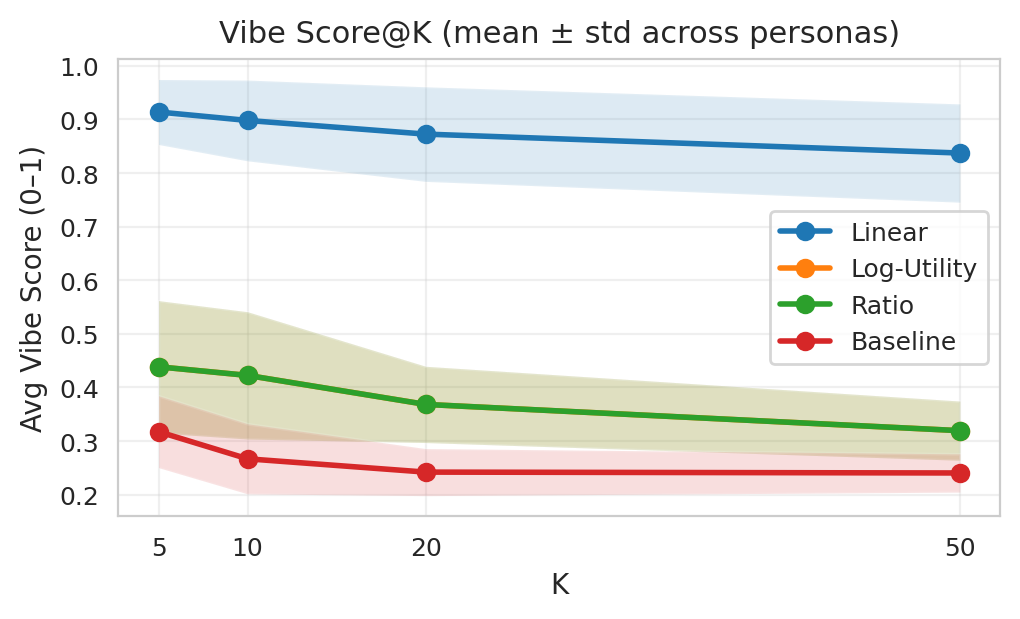

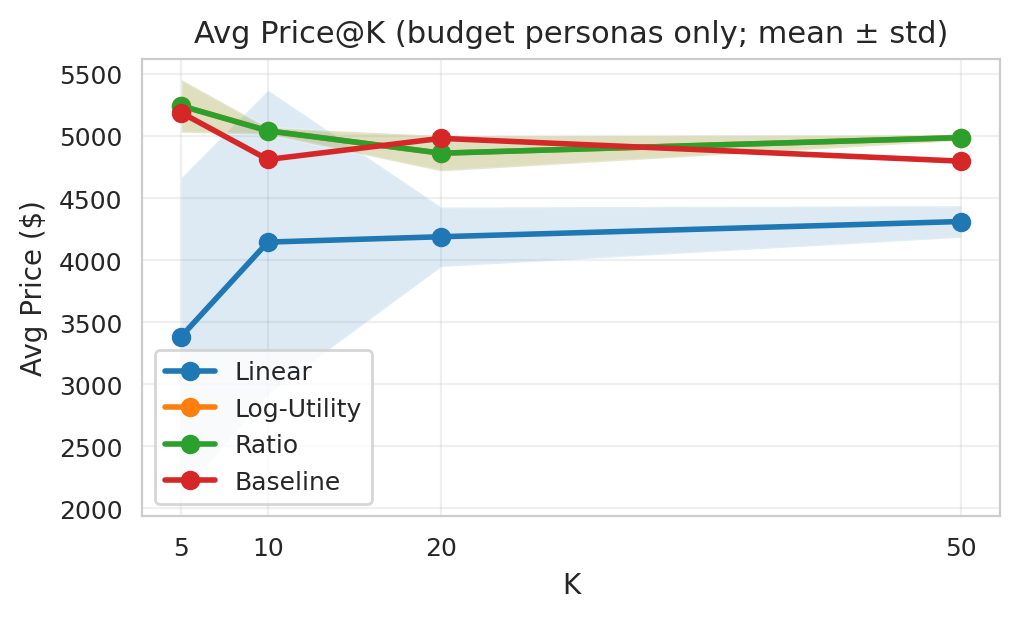

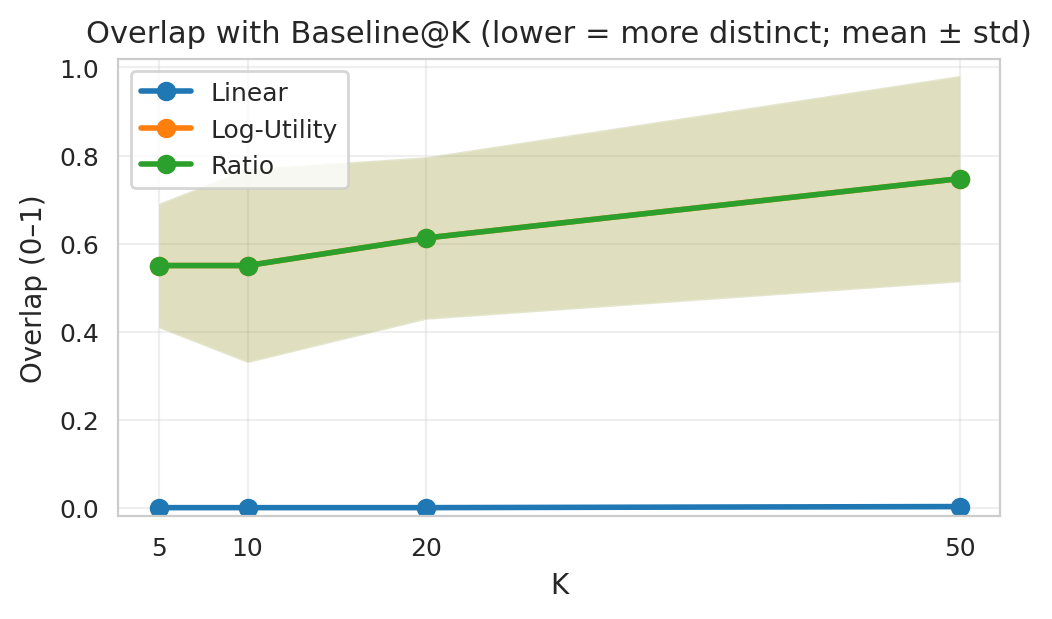

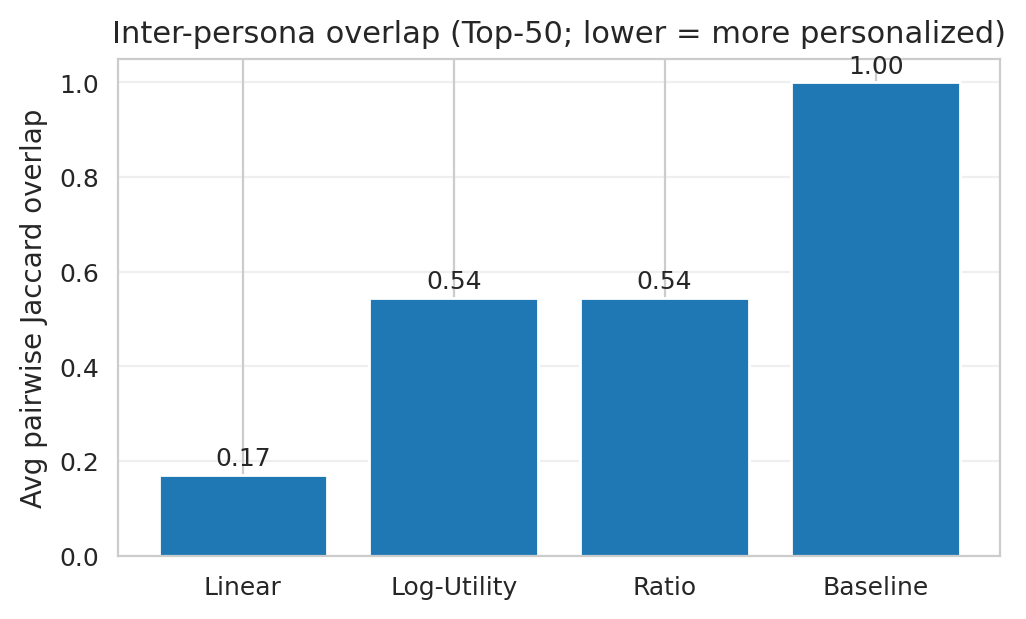

In [0]:
# ============================================================
# Paper-ready plots (no seaborn). Uses matplotlib only.
# Produces:
# 1) VibeScore@K (mean across personas; shaded std)
# 2) AvgPrice@K for budget personas only; shaded std
# 3) Overlap@K vs baseline (exclude baseline); shaded std
# 4) Inter-persona overlap bar chart (Top50 sets)
# 5) Coverage + Pareto inefficiency bar charts (if you have those precomputed)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

# ---------- CONFIG ----------
K_LEVELS = [5, 10, 20, 50]
BUDGET_PERSONAS = ["Broke Student", "Penny Pincher"]  # adjust if needed
FUNC_ORDER = ["Linear", "Log-Utility", "Ratio", "Baseline"]  # keep consistent in all plots

# Matplotlib defaults: clean, paper-ish
plt.rcParams.update({
    "figure.dpi": 200,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

# ---------- HELPERS ----------
def summarize_metric(res_df, metric, personas=None, functions=None):
    d = res_df.copy()
    if personas is not None:
        d = d[d["Persona"].isin(personas)]
    if functions is not None:
        d = d[d["Function"].isin(functions)]

    # mean/std over personas for each (Function, K)
    g = (d.groupby(["Function", "K"])[metric]
           .agg(["mean", "std", "count"])
           .reset_index())
    return g

def plot_line_with_band(summary_df, metric_label, title, ylabel, include_functions):
    fig, ax = plt.subplots(figsize=(5.2, 3.2))

    for func in include_functions:
        s = summary_df[summary_df["Function"] == func].sort_values("K")
        if s.empty:
            continue
        x = s["K"].values
        y = s["mean"].values
        sd = s["std"].fillna(0).values

        ax.plot(x, y, marker="o", linewidth=2, label=func)
        ax.fill_between(x, y - sd, y + sd, alpha=0.15)

    ax.set_title(title)
    ax.set_xlabel("K")
    ax.set_ylabel(ylabel)
    ax.set_xticks(K_LEVELS)
    ax.grid(True, alpha=0.3)
    ax.legend(frameon=True, loc="best")
    plt.tight_layout()
    return fig, ax

def compute_inter_persona_overlap(diversity_results, func, topK=50):
    # diversity_results: list of dicts {"Persona","Function","Top50_IDs":set(...) }
    func_sets = {r["Persona"]: r[f"Top{topK}_IDs"] for r in diversity_results if r["Function"] == func}
    pairs = list(combinations(func_sets.items(), 2))
    if not pairs:
        return np.nan
    overlaps = []
    for (_, s1), (_, s2) in pairs:
        j = len(s1.intersection(s2)) / max(1, len(s1.union(s2)))
        overlaps.append(j)
    return float(np.mean(overlaps))

# ============================================================
# 1) VIBE ACCURACY CURVE (mean ± std across personas)
# ============================================================
vibe_sum = summarize_metric(res_df, "Avg_Vibe_Score", personas=None, functions=FUNC_ORDER)
fig1, ax1 = plot_line_with_band(
    vibe_sum,
    metric_label="Avg_Vibe_Score",
    title="Vibe Score@K (mean ± std across personas)",
    ylabel="Avg Vibe Score (0–1)",
    include_functions=FUNC_ORDER
)

# ============================================================
# 2) PRICE CURVE FOR BUDGET PERSONAS ONLY (mean ± std)
# ============================================================
price_sum = summarize_metric(res_df, "Avg_Price", personas=BUDGET_PERSONAS, functions=FUNC_ORDER)
fig2, ax2 = plot_line_with_band(
    price_sum,
    metric_label="Avg_Price",
    title="Avg Price@K (budget personas only; mean ± std)",
    ylabel="Avg Price ($)",
    include_functions=FUNC_ORDER
)

# ============================================================
# 3) DISTINCTNESS: OVERLAP WITH BASELINE (exclude Baseline line)
# ============================================================
overlap_sum = summarize_metric(res_df, "Overlap", personas=None, functions=["Linear", "Log-Utility", "Ratio"])
fig3, ax3 = plot_line_with_band(
    overlap_sum,
    metric_label="Overlap",
    title="Overlap with Baseline@K (lower = more distinct; mean ± std)",
    ylabel="Overlap (0–1)",
    include_functions=["Linear", "Log-Utility", "Ratio"]
)
ax3.set_ylim(-0.02, 1.02)

# ============================================================
# 4) INTER-PERSONA OVERLAP BAR CHART (Top50 sets)
# Requires diversity_results from your tournament loop
# ============================================================
# If you don't have diversity_results in memory, comment this block out.
if "diversity_results" in globals():
    funcs_for_bar = ["Linear", "Log-Utility", "Ratio", "Baseline"]
    vals = [compute_inter_persona_overlap(diversity_results, f, topK=50) for f in funcs_for_bar]

    fig4, ax4 = plt.subplots(figsize=(5.2, 3.2))
    ax4.bar(funcs_for_bar, vals)
    ax4.set_title("Inter-persona overlap (Top-50; lower = more personalized)")
    ax4.set_ylabel("Avg pairwise Jaccard overlap")
    ax4.grid(True, axis="y", alpha=0.3)
    for i, v in enumerate(vals):
        ax4.text(i, v + 0.01, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
else:
    fig4 = None

# ============================================================
# OPTIONAL: 5) COVERAGE & PARETO BAR PLOTS
# (only if you already computed per-function scalars)
# Example expected variables:
# coverage_pct = {"Linear":0.21, "Ratio":0.11, "Log-Utility":0.11, "Baseline":0.05}
# pareto_missed = {"Linear":1464, "Ratio":16848, "Log-Utility":16848, "Baseline":21742}
# ============================================================
def bar_plot_from_dict(d, title, ylabel, order):
    fig, ax = plt.subplots(figsize=(5.2, 3.2))
    xs = [k for k in order if k in d]
    ys = [d[k] for k in xs]
    ax.bar(xs, ys)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(True, axis="y", alpha=0.3)
    for i, v in enumerate(ys):
        ax.text(i, v + (0.01 * max(ys) if max(ys) else 0.01), f"{v:.3g}", ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    return fig, ax

if "coverage_pct" in globals():
    fig5a, _ = bar_plot_from_dict(
        coverage_pct,
        title="Catalog coverage across personas",
        ylabel="Coverage (% of inventory)",
        order=FUNC_ORDER
    )

if "pareto_missed" in globals():
    fig5b, _ = bar_plot_from_dict(
        pareto_missed,
        title="Pareto inefficiency (avg dominated count)",
        ylabel="Avg # strictly-better items missed",
        order=FUNC_ORDER
    )

# ============================================================
# SAVE FIGURES (paper-ready 300 DPI)
# ============================================================
fig1.savefig("fig_vibe_score_at_k.png", bbox_inches="tight", dpi=300)
fig2.savefig("fig_avg_price_budget_at_k.png", bbox_inches="tight", dpi=300)
fig3.savefig("fig_overlap_with_baseline_at_k.png", bbox_inches="tight", dpi=300)
if fig4 is not None:
    fig4.savefig("fig_inter_persona_overlap_top50.png", bbox_inches="tight", dpi=300)



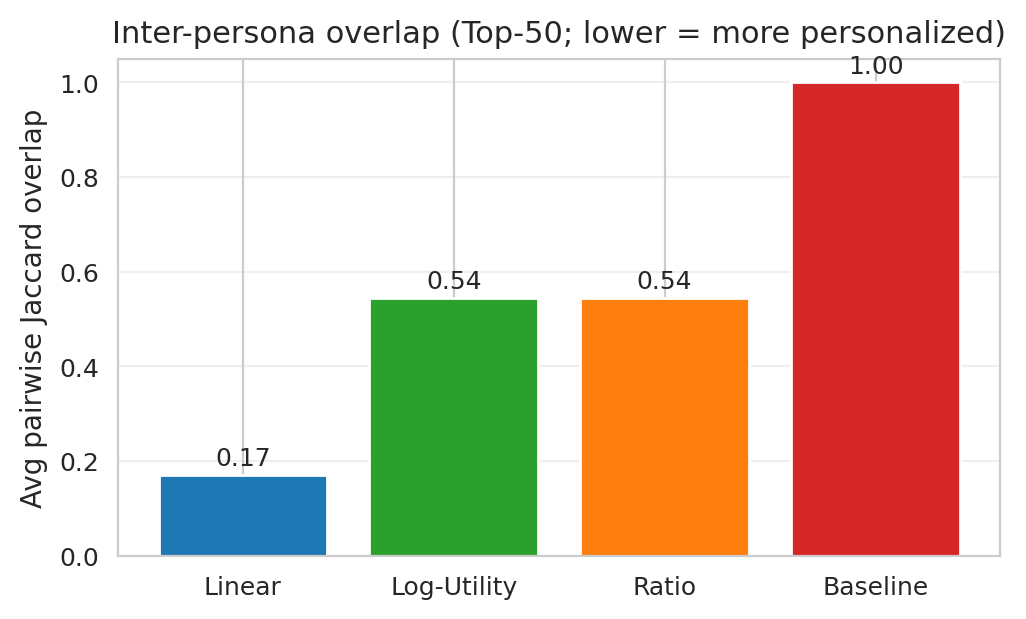

In [0]:
# --- Add this near your config (function -> fixed colors) ---
FUNC_COLORS = {
    "Linear":      "#1f77b4",  # blue
    "Ratio":       "#ff7f0e",  # orange
    "Log-Utility": "#2ca02c",  # green
    "Baseline":    "#d62728",  # red
}

# --- Replace your bar-plot block (Figure 4) with this ---
if "diversity_results" in globals():
    funcs_for_bar = ["Linear", "Log-Utility", "Ratio", "Baseline"]
    vals = [compute_inter_persona_overlap(diversity_results, f, topK=50) for f in funcs_for_bar]
    bar_colors = [FUNC_COLORS[f] for f in funcs_for_bar]

    fig4, ax4 = plt.subplots(figsize=(5.2, 3.2))
    ax4.bar(funcs_for_bar, vals, color=bar_colors)

    ax4.set_title("Inter-persona overlap (Top-50; lower = more personalized)")
    ax4.set_ylabel("Avg pairwise Jaccard overlap")
    ax4.grid(True, axis="y", alpha=0.3)

    for i, v in enumerate(vals):
        ax4.text(i, v + 0.01, f"{v:.2f}", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
else:
    fig4 = None


🚀 Running Advanced Pareto & Coverage Analysis...


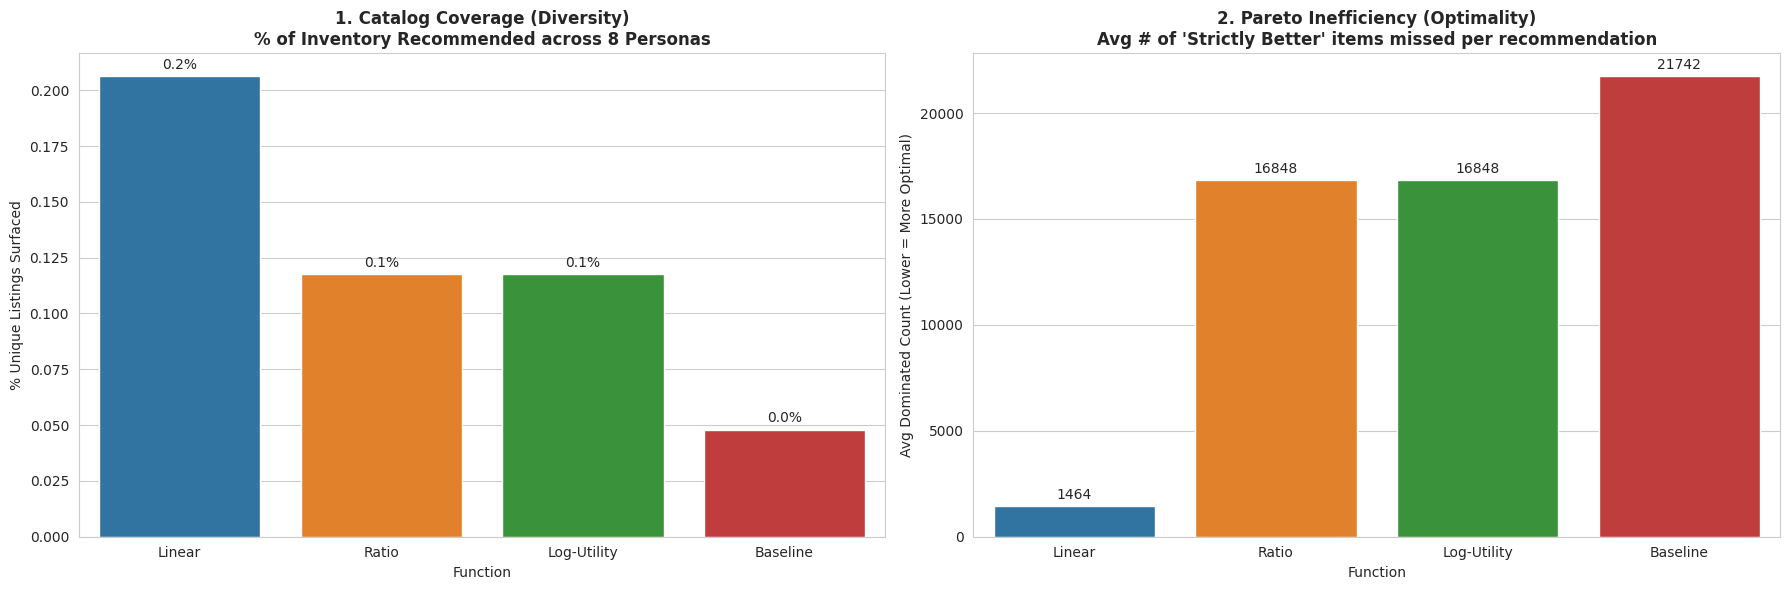

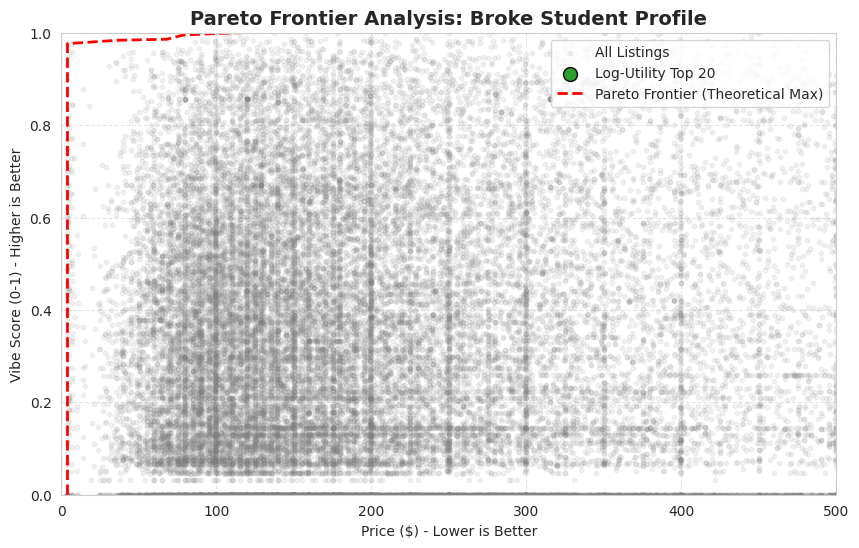

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. SETUP & DATA
# ==========================================
# (Assuming 'df' and 'personas' are already loaded from previous cells)
# We need to ensure df has 'P' (Price) and 'V' (Vibe) columns available.

# Define the metric storage
advanced_metrics = []
total_inventory_size = len(df)
K_FIXED = 20  # We evaluate these metrics at K=20

# ==========================================
# 2. PARETO & COVERAGE LOOP
# ==========================================
print("🚀 Running Advanced Pareto & Coverage Analysis...")

for func in ["Linear", "Ratio", "Log-Utility", "Baseline"]:
    # Track all unique IDs recommended by this function across ALL personas
    all_recommended_ids = set()
    
    pareto_inefficiency_scores = []
    
    for p_name, params in personas.items():
        # A. Calculate User Specific Vibe (V) for this Persona
        # (Re-calculating V column for the specific user view)
        df["V"] = 0
        total_w = sum(params["vibe_pref"].values())
        for col, weight in params["vibe_pref"].items():
            if col in df.columns:
                df["V"] += df[col] * weight
        df["V"] /= (total_w + 1e-6)
        
        # B. Score
        d = df.copy()
        if func == "Linear":
            d["Score"] = params["wQ"]*d["Q"] + params["wA"]*d["A"] + params["wV"]*d["V"] - params["wP"]*d["P"]
        elif func == "Ratio":
            d["Score"] = (d["Q"]**params["wQ"] * (1+d["A"])**params["wA"] * (1+d["V"])**params["wV"]) / (d["P"]**params["wP"])
        elif func == "Log-Utility":
            d["Score"] = params["wQ"]*np.log(d["Q"]) - params["wP"]*np.log(d["P"]) + params["wA"]*np.log1p(d["A"]) + params["wV"]*np.log1p(d["V"])
        elif func == "Baseline":
            d["Score"] = d["Base_Score"]
            
        # C. Get Top K
        top_k_df = d.sort_values("Score", ascending=False).head(K_FIXED)
        
        # --- METRIC 1: COVERAGE ACCUMULATION ---
        all_recommended_ids.update(top_k_df["property_id"].tolist())
        
        # --- METRIC 2: PARETO EFFICIENCY ---
        # For each recommended item, count how many items in the FULL DB dominate it
        # Dominated if: Other_Price < Item_Price AND Other_Vibe > Item_Vibe
        # (We use a sample for speed if DB is huge)
        
        for _, item in top_k_df.iterrows():
            # Vectorized check for dominators
            # "Better" means: Price is lower (d['price'] < item['price']) AND Vibe is higher (d['V'] > item['V'])
            # Note: Using raw 'price' and normalized 'V'
            dominators = d[ (d["price"] < item["price"]) & (d["V"] > item["V"]) ]
            pareto_inefficiency_scores.append(len(dominators))

    # D. Aggregate for this Function
    coverage_pct = (len(all_recommended_ids) / total_inventory_size) * 100
    avg_inefficiency = np.mean(pareto_inefficiency_scores)
    
    advanced_metrics.append({
        "Function": func,
        "Catalog_Coverage_Pct": coverage_pct,
        "Pareto_Inefficiency": avg_inefficiency
    })

adv_df = pd.DataFrame(advanced_metrics)

# ==========================================
# 3. VISUALIZATION
# ==========================================
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Catalog Coverage (Higher is Better)
sns.barplot(data=adv_df, x="Function", y="Catalog_Coverage_Pct", palette=palette, ax=ax[0])
ax[0].set_title(f"1. Catalog Coverage (Diversity)\n% of Inventory Recommended across {len(personas)} Personas", fontsize=12, fontweight='bold')
ax[0].set_ylabel("% Unique Listings Surfaced")
ax[0].bar_label(ax[0].containers[0], fmt='%.1f%%', padding=3)

# Plot 2: Pareto Inefficiency (Lower is Better)
sns.barplot(data=adv_df, x="Function", y="Pareto_Inefficiency", palette=palette, ax=ax[1])
ax[1].set_title("2. Pareto Inefficiency (Optimality)\nAvg # of 'Strictly Better' items missed per recommendation", fontsize=12, fontweight='bold')
ax[1].set_ylabel("Avg Dominated Count (Lower = More Optimal)")
ax[1].bar_label(ax[1].containers[0], fmt='%.0f', padding=3)

plt.tight_layout()
plt.show()

# ==========================================
# 4. PARETO FRONTIER VISUALIZATION (Example)
# ==========================================
# Let's visualize the "Frontier" for one specific persona (Student) to show what "Efficiency" looks like
p_name = "Broke Student"
params = personas[p_name]

# Recalculate V for Student
df["V"] = 0
total_w = sum(params["vibe_pref"].values())
for col, weight in params["vibe_pref"].items():
    if col in df.columns:
        df["V"] += df[col] * weight
df["V"] /= (total_w + 1e-6)

plt.figure(figsize=(10, 6))

# 1. Plot the "Cloud" of all listings
plt.scatter(df["price"], df["V"], alpha=0.1, color="gray", s=10, label="All Listings")

# 2. Plot the Recommendations from our Best Model (e.g., Log-Utility)
# (Re-running scoring specifically for plotting)
d = df.copy()
d["Score"] = params["wQ"]*np.log(d["Q"]) - params["wP"]*np.log(d["P"]) + params["wA"]*np.log1p(d["A"]) + params["wV"]*np.log1p(d["V"])
top_k_ids = d.sort_values("Score", ascending=False).head(20)

plt.scatter(top_k_ids["price"], top_k_ids["V"], color="#2ca02c", s=100, edgecolors='black', label="Log-Utility Top 20")

# 3. Highlight the "True Frontier" (The theoretical best)
# We calculate the convex hull or just scatter the best points
# Simple heuristic: Plot points that have NO dominators (Pareto count = 0)
frontier = []
sorted_by_price = df.sort_values("price")
max_v = -1
for _, row in sorted_by_price.iterrows():
    if row["V"] > max_v:
        frontier.append(row)
        max_v = row["V"]
frontier_df = pd.DataFrame(frontier)

plt.plot(frontier_df["price"], frontier_df["V"], color="red", linestyle="--", linewidth=2, label="Pareto Frontier (Theoretical Max)")

plt.title(f"Pareto Frontier Analysis: {p_name} Profile", fontsize=14, fontweight='bold')
plt.xlabel("Price ($) - Lower is Better")
plt.ylabel("Vibe Score (0-1) - Higher is Better")
plt.xlim(0, 500) # Zoom in to relevant price range
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()